# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm
!pip install torchsummary
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Second Experiment : Model Net2

To get the desired accuracy within desired epochs, we would be using lr scheduler to reduce the lr whne there is a plateau to speed up the ocnvergence.


### LR scheduler to reduce lr on plateau




## Data Transformations


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 99473180.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 80703327.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25184962.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19499005.90it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=32, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:

dropout_value = 0
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10


          # TRANSITION BLOCK 1
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 10
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 5



        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=48, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(48),
            nn.Dropout(dropout_value)
        ) # output_size = 3

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.pool2(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [7]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net2().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [8]:
model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.7, patience=0)

In [9]:
# Data to plot accuracy and loss graphs

train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):

  model.train()

  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  epoch_loss=0


  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)


    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target, reduction='mean')


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    epoch_loss +=loss.item()

    pbar.set_description(desc= f'Batch_id={batch_idx} Batch_Loss={loss.item():0.5f} accuracy={100*correct/processed:0.2f}')


  train_acc.append(100*correct/processed)
  epoch_loss /= len(train_loader)
  train_losses.append(epoch_loss)

  print(f'\nTrain set: Average Loss: {epoch_loss:0.4f} Accuracy : {100*correct/processed:0.2f}%')

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_acc_ = 100. * correct / len(test_loader.dataset)
  print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset),test_acc_))

  test_acc.append(test_acc_)
  return test_loss , test_acc_

# Let's Train and test our model

This time let's add a scheduler for out LR.

In [10]:
# Custom callback class for model saving and ReduceLROnPlateau
class CustomCallback:
  def __init__(self, model):
      self.model = model
      self.best_loss = float('inf')

  def on_epoch_end(self, epoch, metric):
      # Save the model if validation loss improves
      if metric < self.best_loss:
          self.best_loss = metric
          torch.save(self.model.state_dict(), 'best_model.pth')
          print("Model saved as best_model.pth ")

      # Update the scheduler based on the validation loss
      scheduler.step(metric)

# Train your model and update the learning rate using the scheduler
callback = CustomCallback(model)

EPOCHS = 15
for epoch in range(EPOCHS):
    print(f"EPOCH : {epoch} , lr : {optimizer.param_groups[0]['lr']}")

    train(model, device, train_loader, optimizer, epoch)
    test_loss , test_acc_ = test(model, device, test_loader)
    callback.on_epoch_end(epoch, test_loss)


EPOCH : 0 , lr : 0.02


Batch_id=1874 Batch_Loss=0.03886 accuracy=95.36: 100%|██████████| 1875/1875 [00:29<00:00, 63.30it/s]



Train set: Average Loss: 0.1649 Accuracy : 95.36%
Test set: Average loss: 0.0624, Accuracy: 9803/10000 (98.03%)

Model saved as best_model.pth 
EPOCH : 1 , lr : 0.02


Batch_id=1874 Batch_Loss=0.10548 accuracy=98.23: 100%|██████████| 1875/1875 [00:28<00:00, 66.10it/s]


Train set: Average Loss: 0.0587 Accuracy : 98.23%


Test set: Average loss: 0.0422, Accuracy: 9876/10000 (98.76%)

Model saved as best_model.pth 
EPOCH : 2 , lr : 0.02


Batch_id=1874 Batch_Loss=0.08238 accuracy=98.55: 100%|██████████| 1875/1875 [00:30<00:00, 61.89it/s]


Train set: Average Loss: 0.0470 Accuracy : 98.55%


Test set: Average loss: 0.0322, Accuracy: 9892/10000 (98.92%)

Model saved as best_model.pth 
EPOCH : 3 , lr : 0.02


Batch_id=1874 Batch_Loss=0.08055 accuracy=98.75: 100%|██████████| 1875/1875 [00:28<00:00, 65.55it/s]


Train set: Average Loss: 0.0397 Accuracy : 98.75%


Test set: Average loss: 0.0525, Accuracy: 9827/10000 (98.27%)

EPOCH : 4 , lr : 0.013999999999999999


Batch_id=1874 Batch_Loss=0.00135 accuracy=99.03: 100%|██████████| 1875/1875 [00:28<00:00, 65.78it/s]



Train set: Average Loss: 0.0318 Accuracy : 99.03%
Test set: Average loss: 0.0245, Accuracy: 9917/10000 (99.17%)

Model saved as best_model.pth 
EPOCH : 5 , lr : 0.013999999999999999


Batch_id=1874 Batch_Loss=0.00983 accuracy=99.10: 100%|██████████| 1875/1875 [00:28<00:00, 66.03it/s]


Train set: Average Loss: 0.0282 Accuracy : 99.10%


Test set: Average loss: 0.0220, Accuracy: 9924/10000 (99.24%)

Model saved as best_model.pth 
EPOCH : 6 , lr : 0.013999999999999999


Batch_id=1874 Batch_Loss=0.00487 accuracy=99.27: 100%|██████████| 1875/1875 [00:28<00:00, 65.49it/s]



Train set: Average Loss: 0.0251 Accuracy : 99.27%
Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

Model saved as best_model.pth 
EPOCH : 7 , lr : 0.013999999999999999


Batch_id=1874 Batch_Loss=0.02725 accuracy=99.27: 100%|██████████| 1875/1875 [00:29<00:00, 63.37it/s]


Train set: Average Loss: 0.0236 Accuracy : 99.27%


Test set: Average loss: 0.0229, Accuracy: 9926/10000 (99.26%)

EPOCH : 8 , lr : 0.009799999999999998


Batch_id=1874 Batch_Loss=0.00624 accuracy=99.39: 100%|██████████| 1875/1875 [00:29<00:00, 64.25it/s]


Train set: Average Loss: 0.0195 Accuracy : 99.39%


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

Model saved as best_model.pth 
EPOCH : 9 , lr : 0.009799999999999998


Batch_id=1874 Batch_Loss=0.00247 accuracy=99.41: 100%|██████████| 1875/1875 [00:30<00:00, 61.44it/s]


Train set: Average Loss: 0.0183 Accuracy : 99.41%


Test set: Average loss: 0.0218, Accuracy: 9933/10000 (99.33%)

EPOCH : 10 , lr : 0.006859999999999998


Batch_id=1874 Batch_Loss=0.00364 accuracy=99.53: 100%|██████████| 1875/1875 [00:30<00:00, 61.25it/s]


Train set: Average Loss: 0.0157 Accuracy : 99.53%


Test set: Average loss: 0.0218, Accuracy: 9928/10000 (99.28%)

EPOCH : 11 , lr : 0.004801999999999998


Batch_id=1874 Batch_Loss=0.00180 accuracy=99.56: 100%|██████████| 1875/1875 [00:29<00:00, 63.34it/s]


Train set: Average Loss: 0.0143 Accuracy : 99.56%


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

Model saved as best_model.pth 
EPOCH : 12 , lr : 0.004801999999999998


Batch_id=1874 Batch_Loss=0.00413 accuracy=99.60: 100%|██████████| 1875/1875 [00:29<00:00, 64.11it/s]


Train set: Average Loss: 0.0137 Accuracy : 99.60%


Test set: Average loss: 0.0190, Accuracy: 9943/10000 (99.43%)

Model saved as best_model.pth 
EPOCH : 13 , lr : 0.004801999999999998


Batch_id=1874 Batch_Loss=0.00098 accuracy=99.63: 100%|██████████| 1875/1875 [00:31<00:00, 59.22it/s]


Train set: Average Loss: 0.0130 Accuracy : 99.63%


Test set: Average loss: 0.0198, Accuracy: 9937/10000 (99.37%)

EPOCH : 14 , lr : 0.0033613999999999983


Batch_id=1874 Batch_Loss=0.00190 accuracy=99.62: 100%|██████████| 1875/1875 [00:31<00:00, 60.43it/s]


Train set: Average Loss: 0.0118 Accuracy : 99.62%


Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)



Text(0.5, 1.0, 'Test Accuracy')

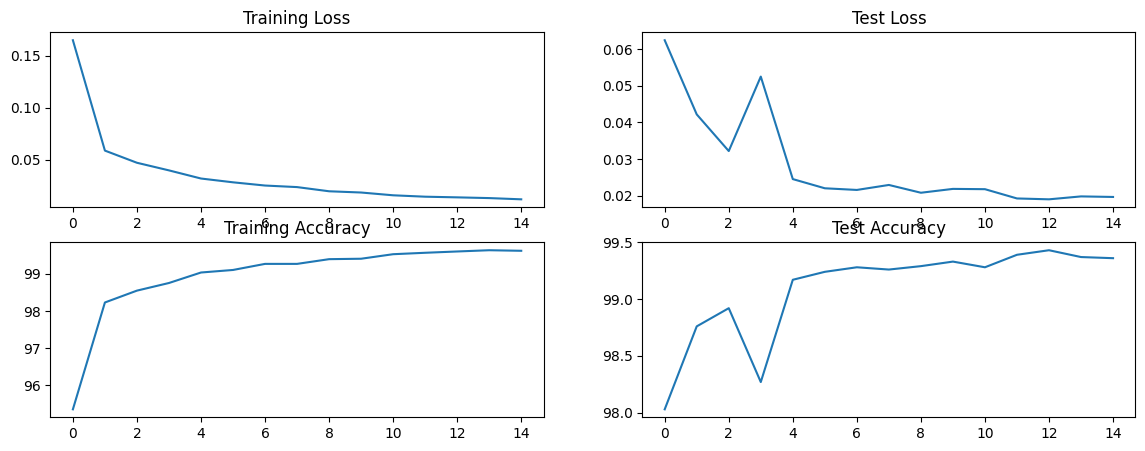

In [11]:
%matplotlib inline
fig, axs = plt.subplots(2,2,figsize=(14,5))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Incorrect predictions in test data

<ipython-input-12-bbd7972413b8>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


total incorrect samples: 64


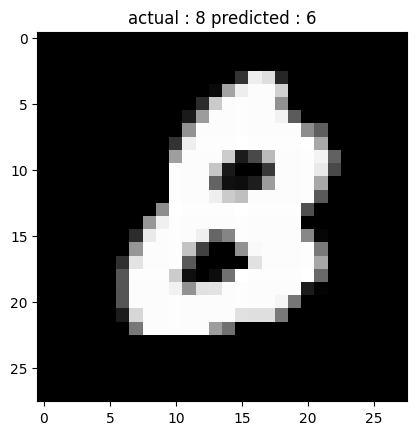

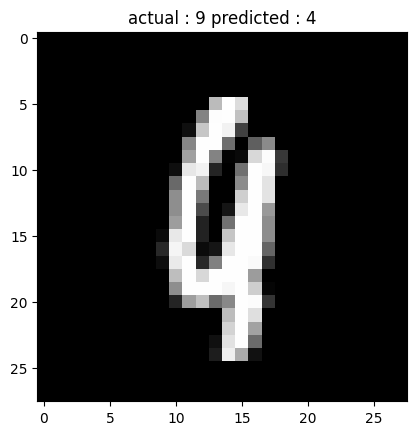

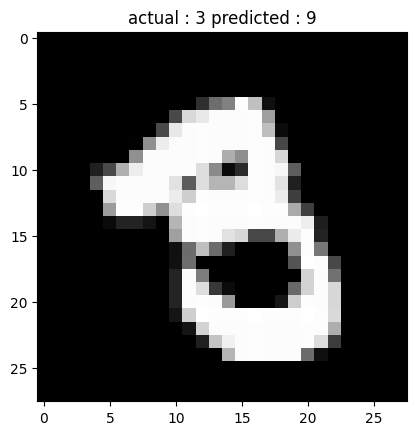

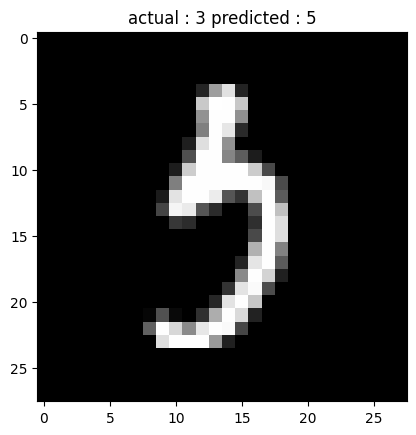

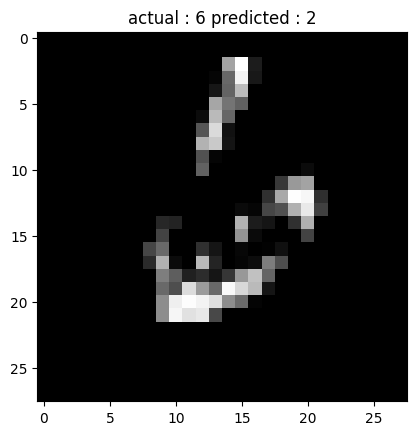

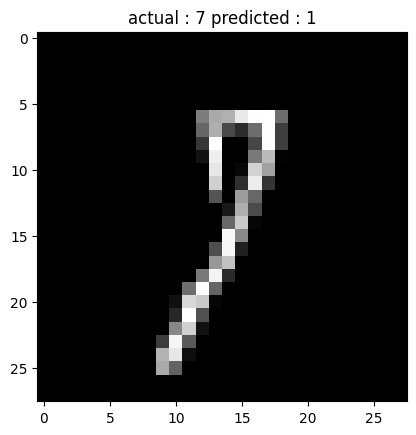

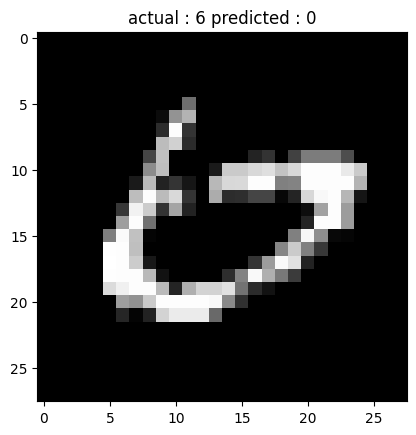

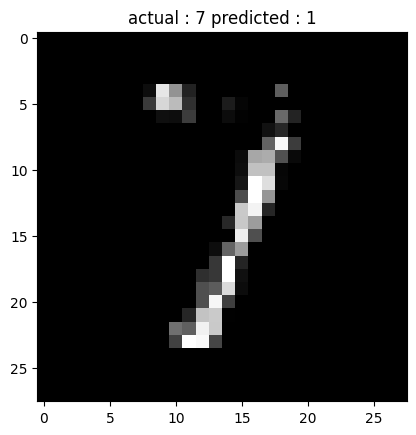

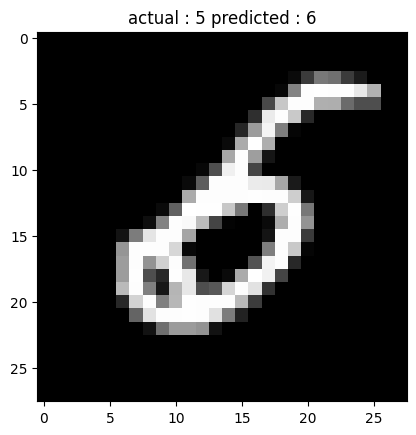

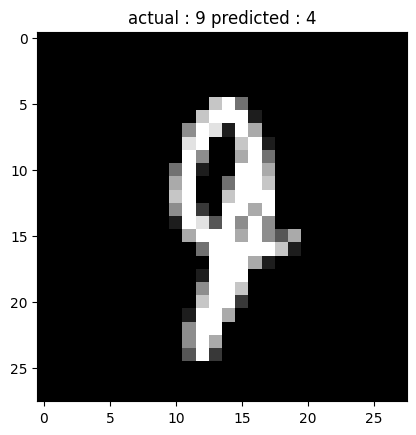

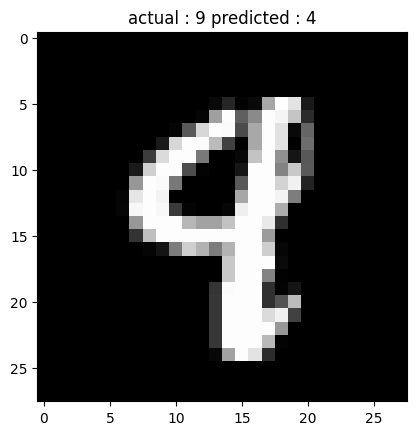

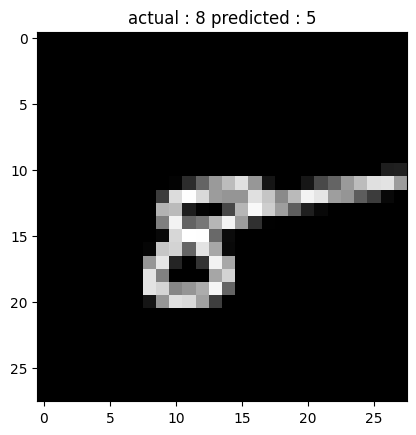

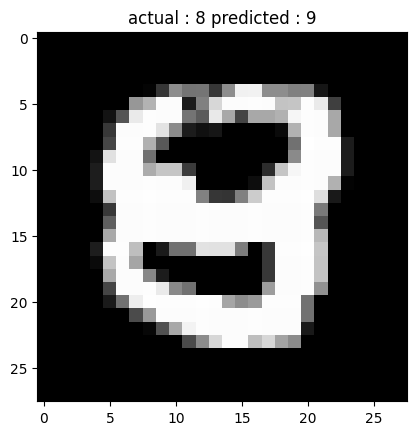

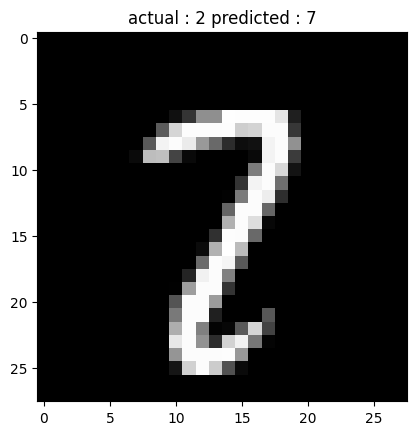

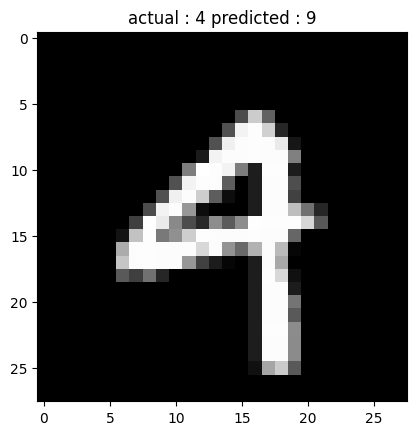

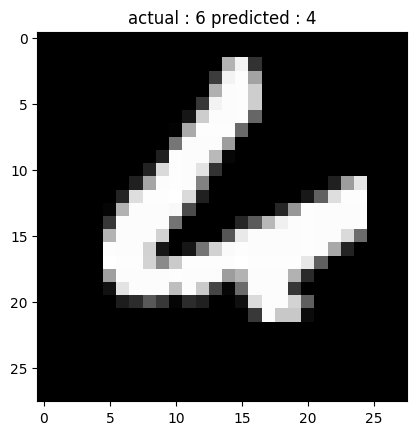

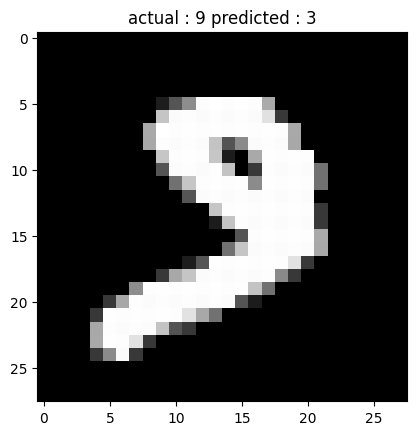

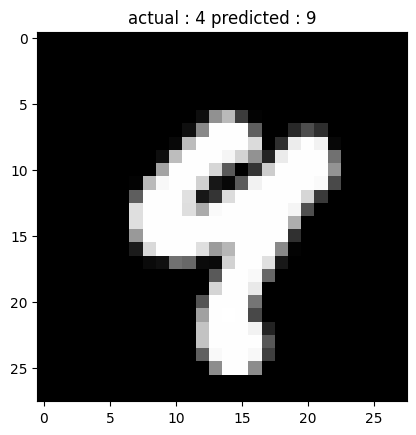

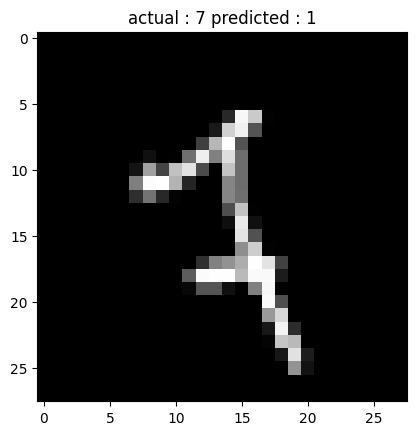

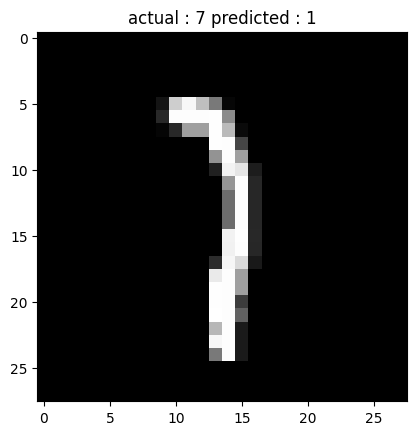

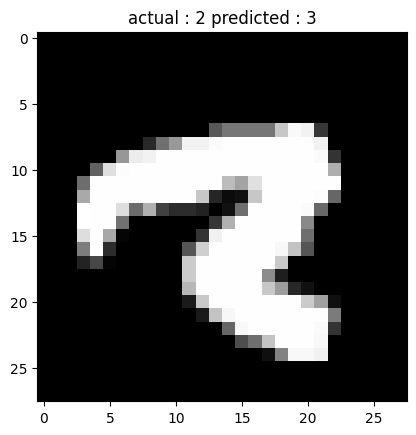

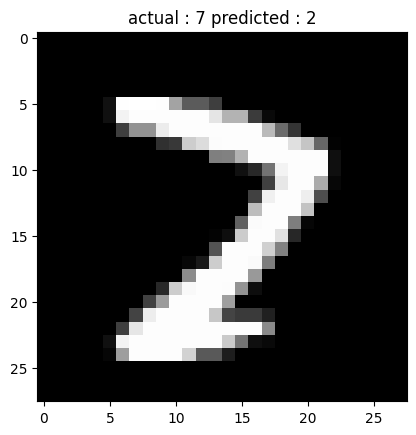

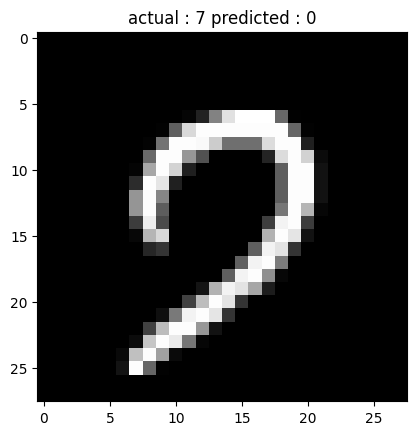

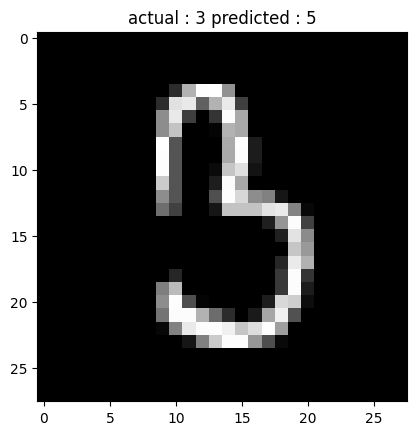

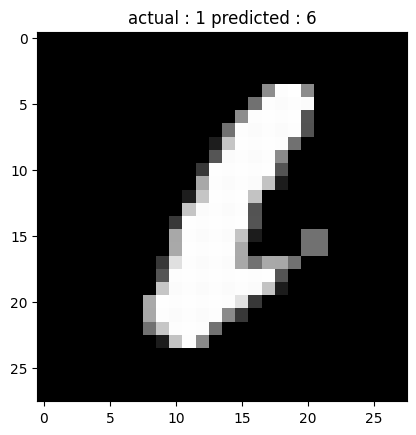

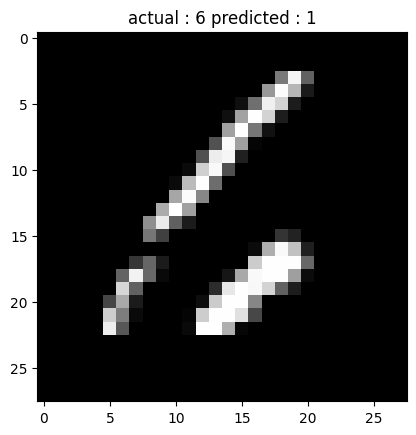

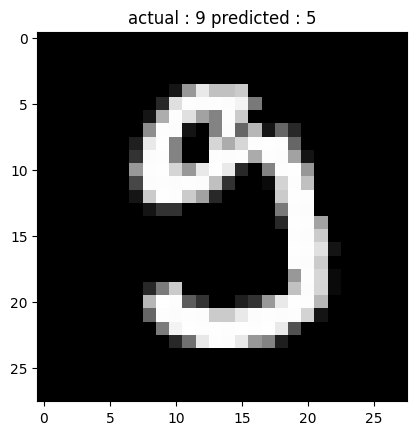

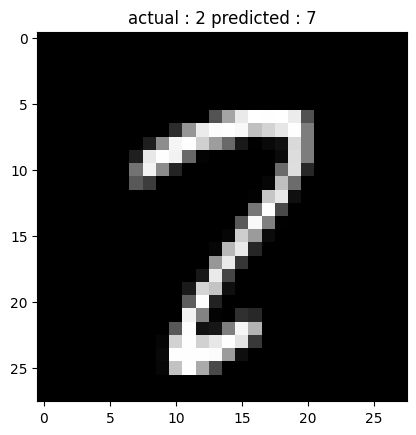

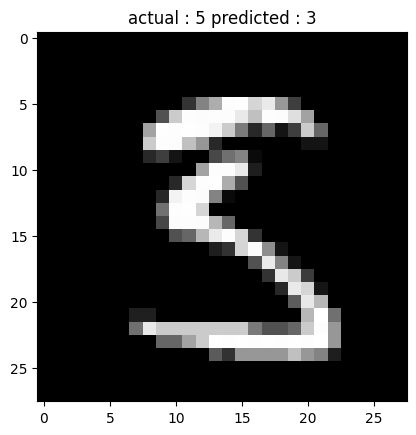

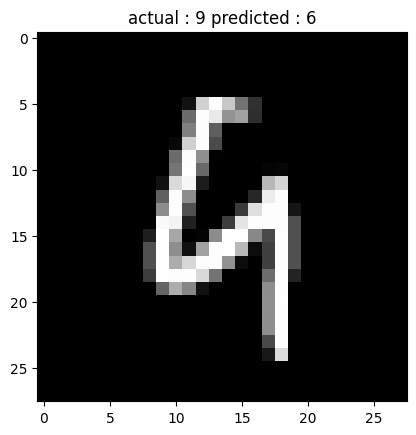

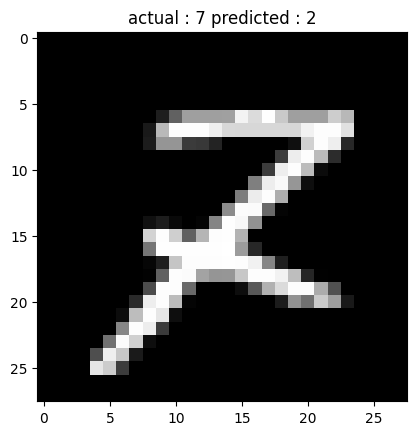

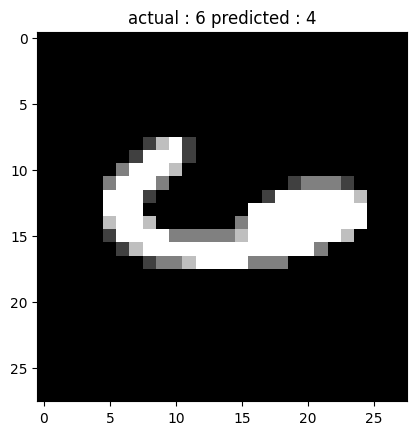

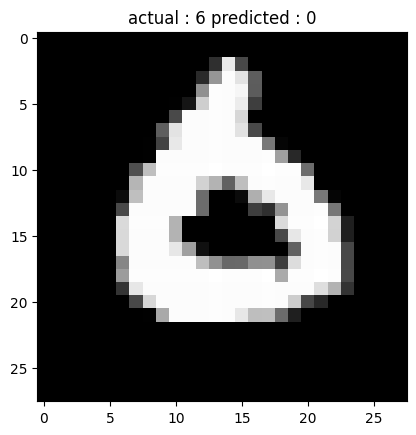

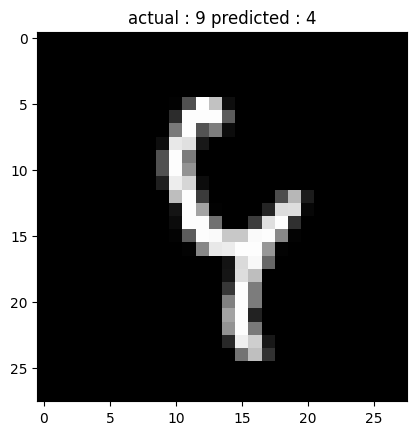

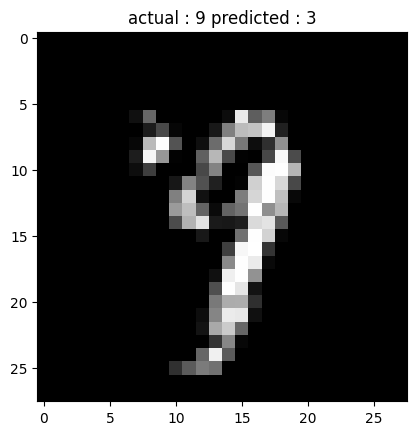

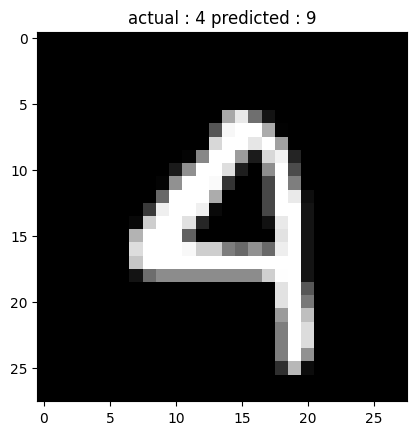

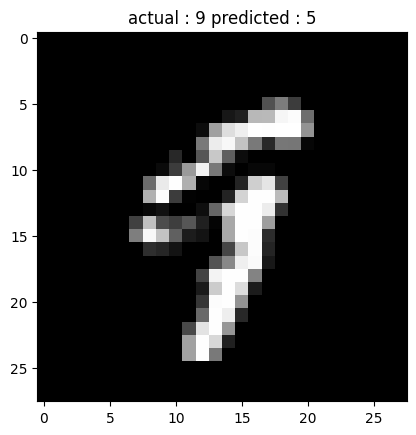

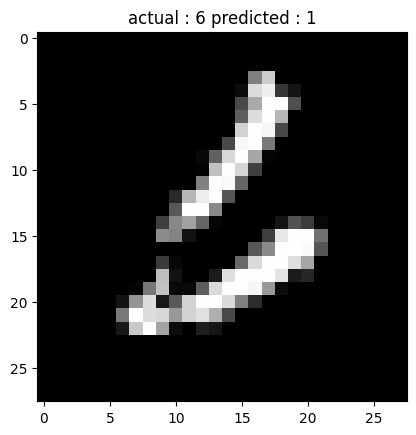

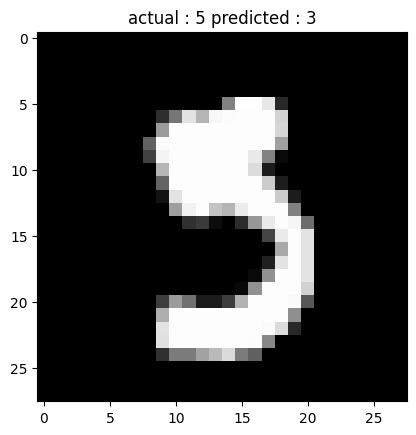

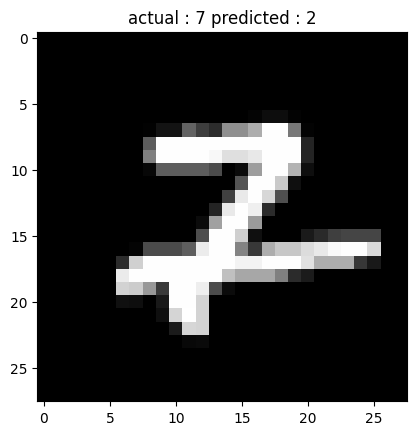

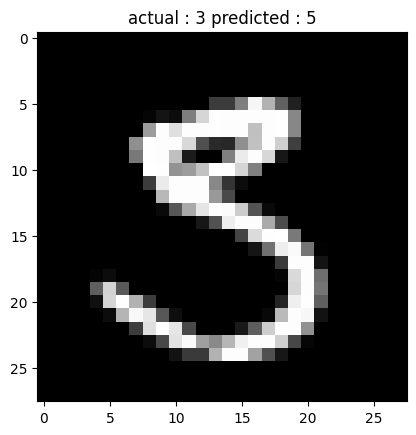

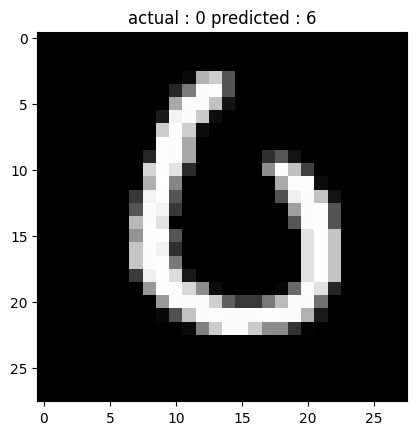

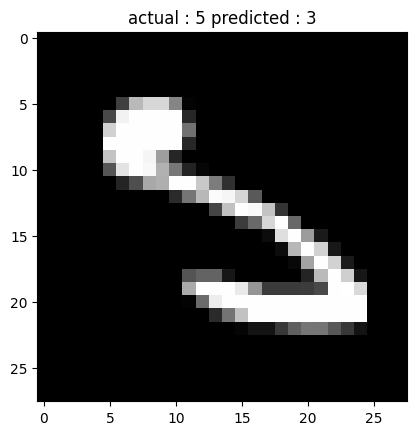

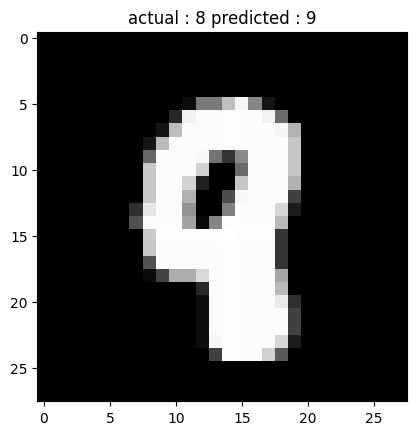

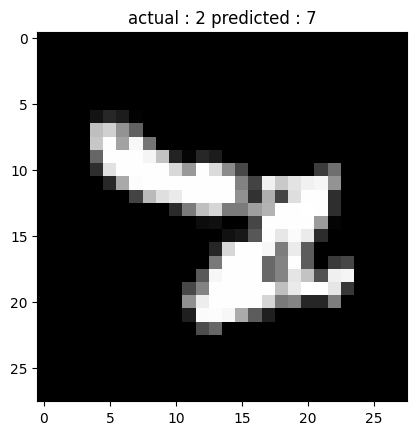

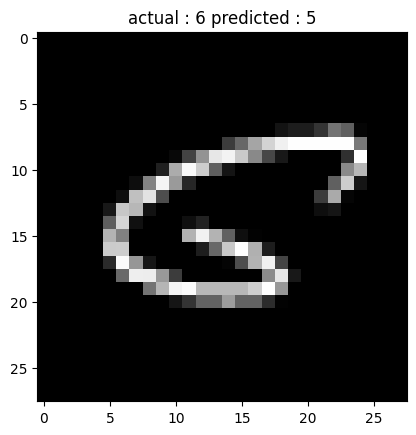

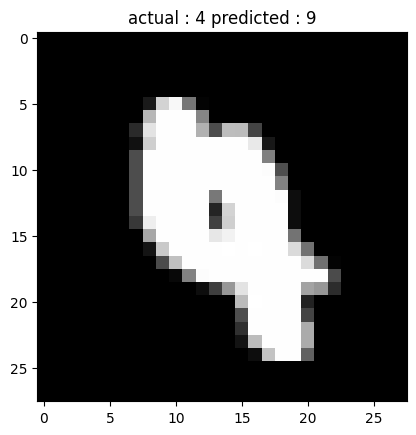

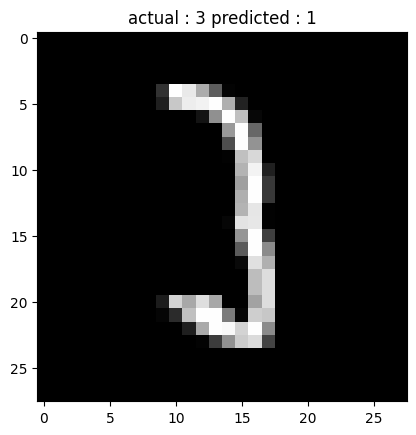

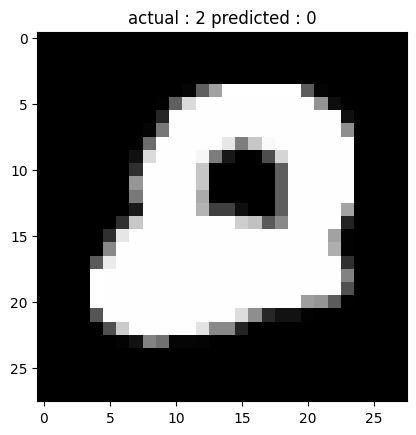

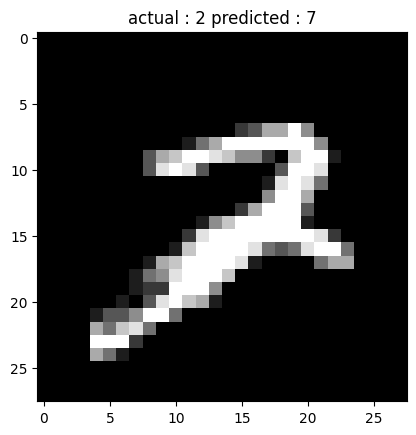

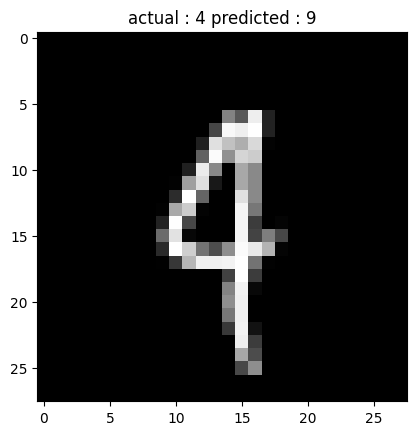

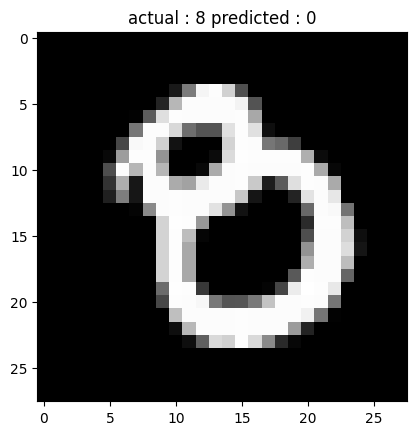

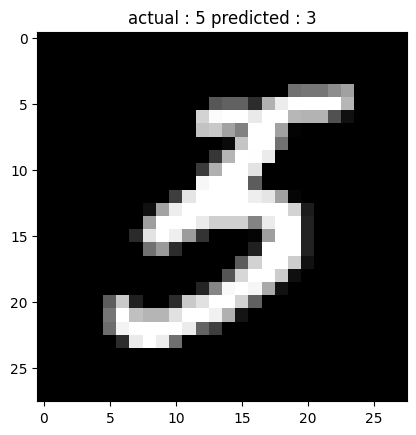

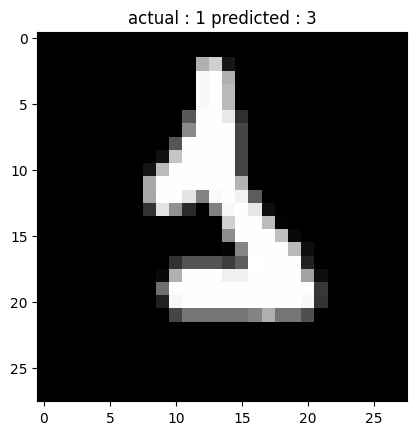

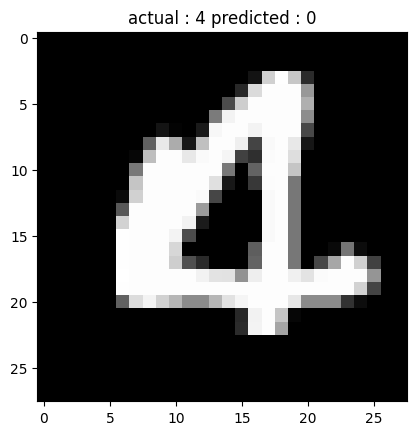

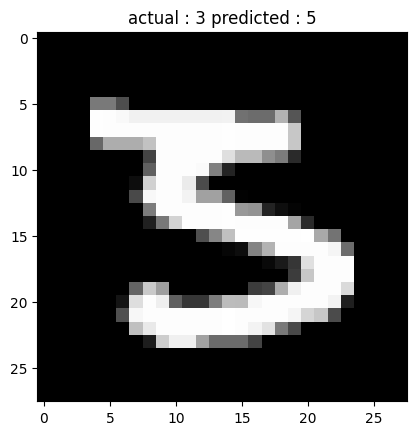

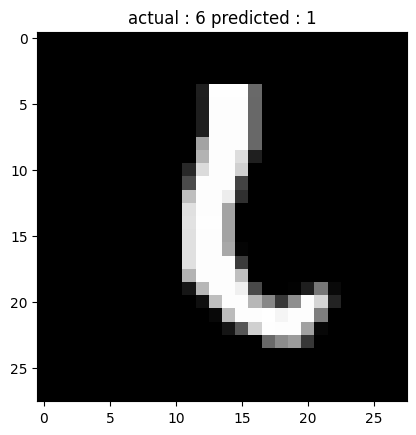

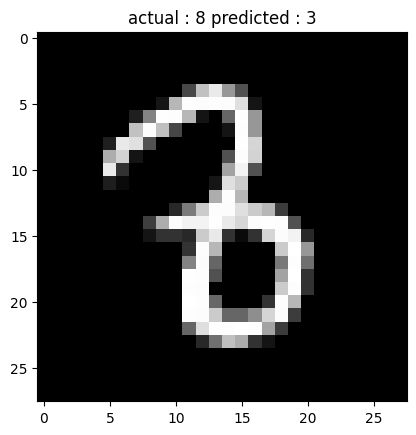

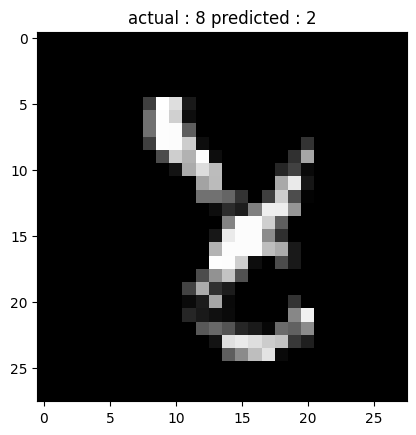

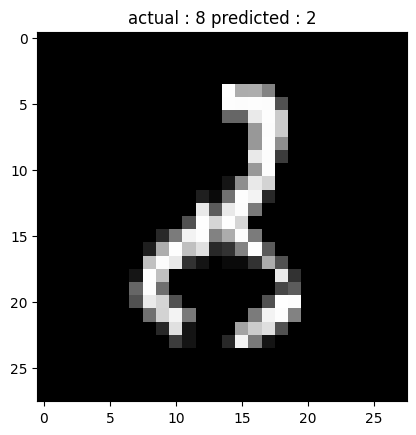

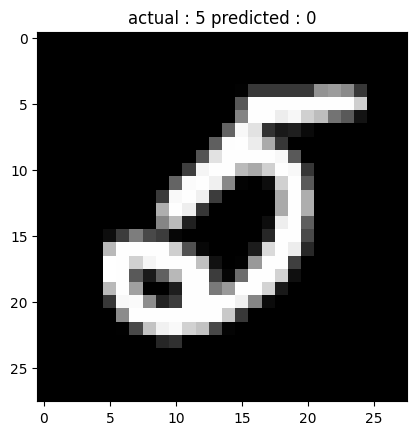

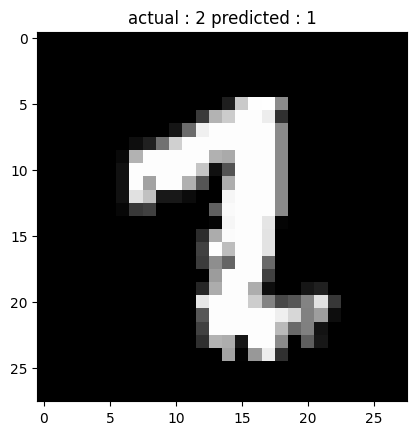

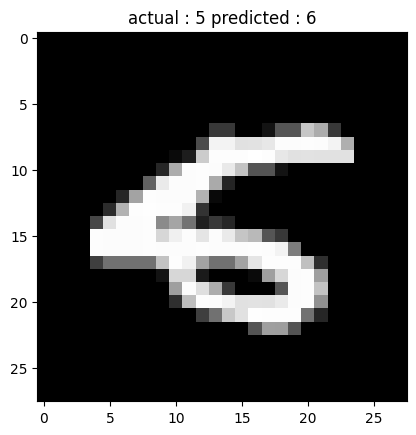

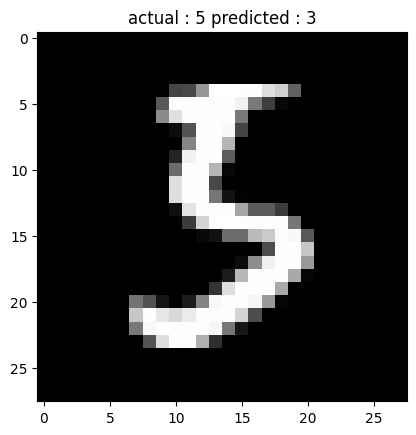

In [12]:
n=0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        non_matching_values = target[target != pred.view_as(target)]

        if len(non_matching_values)>0:
          data, target , pred  = data.to('cpu'), target.to('cpu') , pred.to('cpu')
          for i,j in enumerate(data[target != pred.view_as(target)]):
            n+=1
            fig = plt.figure()
            plt.title(f'actual : {target[target != pred.view_as(target)][i]} predicted : {pred[target != pred.view_as(target)][i].item()}')
            plt.imshow(j.squeeze(0), cmap='gray')

          #break
print(f'total incorrect samples: {n}')
